# Perform VoI calculation using GP surrogate over join action-uncertainty space

In [56]:
import os
import time
import numpy as np
from tqdm import tqdm

from sys_eval import evaluate_system
from schema_builder import build_schema

from scipy.stats import qmc
import sklearn.gaussian_process as gp
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
ids = [11]

In [3]:
# Define base parameters.
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}
base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_test'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': None,
    'battery_power_capacities': [342.0], # [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': None,
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [105]:
def construct_and_evaluate_system(battery_capacities,solar_capacities,battery_efficiencies,base_kwargs):

    base_kwargs.update({
                'battery_energy_capacities': battery_capacities,
                'battery_efficiencies': battery_efficiencies,
                'pv_power_capacities': solar_capacities
            })
    schema_path = build_schema(**base_kwargs)

    eval_results = evaluate_system(schema_path,pricing_dict,opex_factor,suppress_output=True)

    return eval_results['objective']

## Step 1: Train GP Surrogate

Note: probably sensible to conduct an initial rough space search to identify sensible bounds as we expect the objective (cost) to be behaviour reasonably nicely, at least far from the region of the optimum.
The smaller the bounded region the better the surrogate will be and the easier the global optimisation will be - however as these bounds are arbitrary, if we encounter boundary solutions, the bounds need to be extended.

Remeber to note Dom's alternative suggestion for learning a surrogate, and it's motivation from the smoothness of his posterior solution results

In [4]:
# Perform sampling of action-uncertainty space
seed = 42
n_samples = 100

# Space filling sampling of action sub-space using Latin Hypercube
lower_bounds = np.array([*[1e2]*len(ids),*[1e2]*len(ids)])
upper_bounds = np.array([*[2.5e3]*len(ids),*[2.5e3]*len(ids)])

action_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_samples = action_sampler.random(n=n_samples)
action_samples = qmc.scale(action_samples, lower_bounds, upper_bounds)

# Sample from prior distributions of uncertain parameters
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# Combine samples from two sub-spaces
space_samples = np.hstack([action_samples,eta_samples])

In [5]:
# Evaluate system cost over samples.
costs = []

for n in tqdm(range(n_samples)):
    cost = construct_and_evaluate_system(action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs)
    costs.append(cost)

100%|██████████| 100/100 [49:28<00:00, 29.68s/it]


In [23]:
# Train Gaussian Process surrogate.

kernel = 1 * gp.kernels.RBF(length_scale=np.ones(len(ids)*3))
gp_surrogate = gp.GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=5)
gp_surrogate.fit(space_samples, costs)
gp_surrogate.kernel_

1.93**2 * RBF(length_scale=[973, 347, 1.03])

Training the GP properly seems to be a bit of an issue - the length scales that comes out of the optimiser are sometimes completely off

In [24]:
mean_prediction, std_prediction = gp_surrogate.predict(space_samples, return_std=True)

In [77]:
# Visual surrogate model.

# Create set of points in action sub-space to interpolate to
n_predict_points = 1000
action_predict_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_predict_samples = action_predict_sampler.random(n=n_predict_points)
action_predict_samples = qmc.scale(action_predict_samples, lower_bounds, upper_bounds)

# Compute mean cost predicted by surrogate model.
cost_predictions = []

n_MC_samples = 1000
for sample in tqdm(action_predict_samples):
    eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)
    predict_points = np.hstack([np.tile(sample,(n_MC_samples,1)),eta_samples])
    mean_prediction = gp_surrogate.predict(predict_points)
    cost_predictions.append(np.mean(mean_prediction))

100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]


Text(0, 0.5, 'Solar power capacity (kWp)')

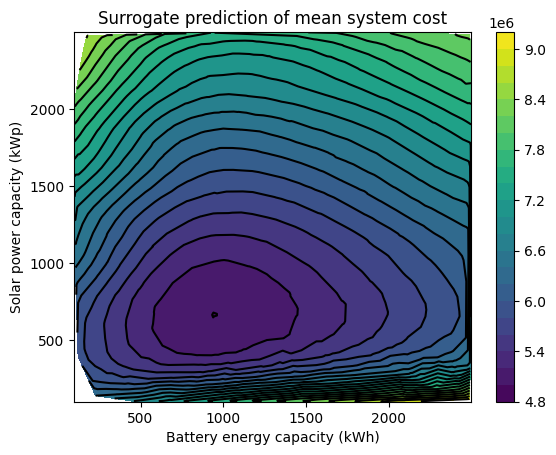

In [78]:
# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,cost_predictions,levels=n_levels)
ax.tricontour(triang, cost_predictions,levels=n_levels, colors='k')
fig.colorbar(tcf)
ax.set_title("Surrogate prediction of mean system cost")
ax.set_xlabel("Battery energy capacity (kWh)")
ax.set_ylabel("Solar power capacity (kWp)")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 24512.90it/s]

[0.82852224]


Text(0.5, 1.0, 'Surrogate prediction of system cost for eta=0.8285')

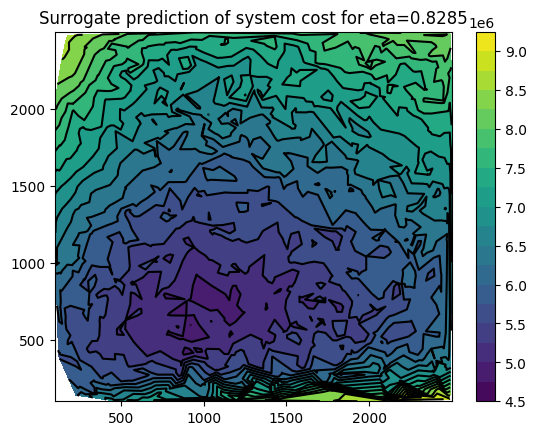

In [79]:
# Compute cost predicted by surrogate model for specific eta.
se_cost_predictions = []

for sample in tqdm(action_predict_samples):
    eta_sample = np.random.normal(loc=mu,scale=sigma,size=(len(ids)))
    predict_points = np.hstack([sample,eta_sample])
    mean_prediction = gp_surrogate.predict([predict_points])
    se_cost_predictions.append(np.mean(mean_prediction))

print(eta_sample)

# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,se_cost_predictions,levels=n_levels)
ax.tricontour(triang, se_cost_predictions,levels=n_levels, colors='k')
fig.colorbar(tcf)
ax.set_title(f"Surrogate prediction of system cost for eta=%s"%round(eta_sample[0],4))

### Investigate convergence of MC estimate using surrogate model

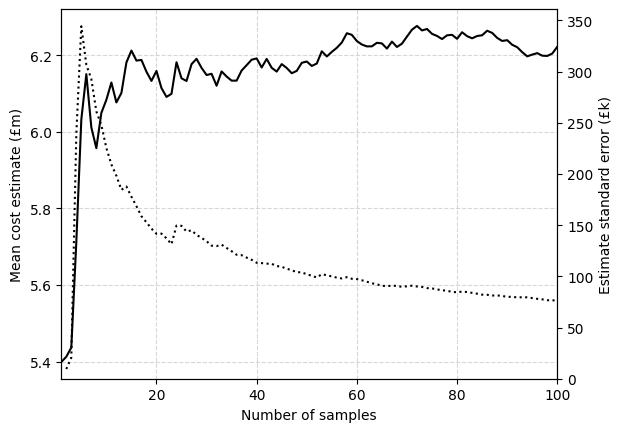

In [104]:
# use last cost_predictions as test case
n_draws = 100

MC_means = [np.mean(cost_predictions[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_predictions[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

## Step 2: Solve Prior Problem using Surrogate

In [88]:
# Define fn of mean system cost predicted by surrogate.
def mean_cost_surrogate_estimate(x, surrogate, n_MC_samples, eta_mu, eta_sigma):

    assert len(x) % 2 == 0, "Design variable argument must have even length."

    # Make draw from distribution of uncertainties - specified in args (mu, sigma)
    # ========================================================================
    eta_samples = np.random.normal(loc=eta_mu,scale=eta_sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)

    # Predict costs for each efficiency sample at target point using surrogate
    # ========================================================================
    predict_points = np.hstack([np.tile(x,(n_MC_samples,1)),eta_samples])
    mean_prediction = surrogate.predict(predict_points)

    return np.mean(mean_prediction)

In [89]:
bounds = op.Bounds(lb=lower_bounds,ub=upper_bounds)
n_MC_samples = 1000

In [109]:
prior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_MC_samples,mu,sigma), seed=seed)
print(prior_soln.x, prior_soln.fun, prior_soln.message)
prior_design = prior_soln.x
prior_cost = prior_soln.fun
print(prior_cost)

[866.47721208 664.85786933] 4980925.757715989 Optimization terminated successfully.
4980925.757715989


### Test quality of surrogate optimal solution

In [111]:
n_MC_samples = 100
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

sample_costs = []

for eta_sample in tqdm(eta_samples):
    sample_cost = construct_and_evaluate_system(prior_design[:len(ids)],prior_design[len(ids):],eta_sample,base_kwargs)
    sample_costs.append(sample_cost)

true_prior_soln_cost_estimate = np.mean(sample_costs)

print(f"Surrogate optimal solution fn error: {round((np.abs(true_prior_soln_cost_estimate-prior_cost)/true_prior_soln_cost_estimate)*100,2)}%")

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Step 3: Solve Pre-Posterior Problem using Surrogate

In [102]:
# Sample from prior distribution of uncertainties.
n_prior_samples = 100
prior_eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_prior_samples,len(ids)))
prior_eta_samples = np.clip(prior_eta_samples,0,1)

In [103]:
posterior_sigma = 0.025 # define measurment uncertainty

posterior_optimal_costs = []

# Solve posterior problem for each eta sample.
for eta_sample in tqdm(prior_eta_samples):
    posterior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_MC_samples,eta_sample,posterior_sigma), seed=seed)
    #print(eta_sample, posterior_soln.x, posterior_soln.fun, posterior_soln.message)
    posterior_optimal_costs.append(posterior_soln.fun)

preposterior_cost = np.mean(posterior_optimal_costs)
print(preposterior_cost)

  1%|          | 1/100 [00:10<16:35, 10.05s/it]

[0.82682759] [961.85898127 654.3792708 ] 5025836.068588528 Optimization terminated successfully.


  2%|▏         | 2/100 [00:23<19:50, 12.15s/it]

[0.96965188] [973.98703361 682.66188406] 4835240.183003588 Optimization terminated successfully.


  3%|▎         | 3/100 [00:33<18:00, 11.14s/it]

[0.68672237] [966.17412142 637.12943158] 5215429.361248543 Optimization terminated successfully.


  4%|▍         | 4/100 [00:51<22:18, 13.94s/it]

[0.84804332] [945.30703584 660.08137299] 4996833.903281487 Optimization terminated successfully.


  5%|▌         | 5/100 [01:03<20:42, 13.08s/it]

[0.76960844] [966.17412142 637.12943158] 5104112.305122297 Optimization terminated successfully.


  6%|▌         | 6/100 [01:18<21:42, 13.86s/it]

[0.86656876] [945.30703584 660.08137299] 4972029.718270988 Optimization terminated successfully.


  7%|▋         | 7/100 [01:29<19:41, 12.71s/it]

[0.81097974] [936.10002629 651.39182005] 5048623.35227671 Optimization terminated successfully.


  8%|▊         | 8/100 [01:42<19:38, 12.81s/it]

[0.89597014] [994.1779655  698.75596288] 4934374.030616768 Optimization terminated successfully.


  9%|▉         | 9/100 [01:55<19:36, 12.93s/it]

[0.86822862] [977.33827567 633.8276982 ] 4972391.142906545 Optimization terminated successfully.


 10%|█         | 10/100 [02:08<19:30, 13.00s/it]

[0.85606694] [977.12112393 675.45963226] 4986386.126110772 Optimization terminated successfully.


 11%|█         | 11/100 [02:22<19:57, 13.46s/it]

[0.88900477] [924.74195581 690.22184404] 4945279.5890378775 Optimization terminated successfully.


 12%|█▏        | 12/100 [02:32<18:09, 12.38s/it]

[0.83647231] [936.10002629 651.39182005] 5013918.023761949 Optimization terminated successfully.


 13%|█▎        | 13/100 [02:45<17:55, 12.36s/it]

[0.87763908] [955.93643535 685.11333536] 4958049.043968329 Optimization terminated successfully.


 14%|█▍        | 14/100 [02:55<16:48, 11.73s/it]

[0.80245761] [931.22349027 638.58542055] 5059864.359523199 Optimization terminated successfully.


 15%|█▌        | 15/100 [03:06<16:28, 11.63s/it]

[0.70877274] [930.63931323 644.78578894] 5185839.37447713 Optimization terminated successfully.


 16%|█▌        | 16/100 [03:17<15:48, 11.29s/it]

[0.76965718] [958.58725936 601.00403384] 5107669.263275132 Optimization terminated successfully.


 17%|█▋        | 17/100 [03:28<15:30, 11.21s/it]

[0.79322738] [936.10002629 651.39182005] 5072367.271577921 Optimization terminated successfully.


 18%|█▊        | 18/100 [03:38<14:56, 10.93s/it]

[0.77042712] [961.85898127 654.3792708 ] 5101462.1998328585 Optimization terminated successfully.


 19%|█▉        | 19/100 [03:50<15:04, 11.17s/it]

[0.76206525] [984.13198919 665.70561113] 5114918.8731197305 Optimization terminated successfully.


 20%|██        | 20/100 [04:03<15:44, 11.81s/it]

[0.90132414] [947.89241127 651.46768655] 4926695.622985059 Optimization terminated successfully.


 21%|██        | 21/100 [04:15<15:38, 11.88s/it]

[0.82704802] [961.85898127 654.3792708 ] 5024386.746382342 Optimization terminated successfully.


 22%|██▏       | 22/100 [04:28<15:51, 12.20s/it]

[0.88350322] [1011.5365242   682.21213587] 4949999.642227066 Optimization terminated successfully.


 23%|██▎       | 23/100 [04:42<16:21, 12.75s/it]

[0.99821155] [958.44069603 674.44643116] 4809356.894374225 Optimization terminated successfully.


 24%|██▍       | 24/100 [04:55<16:17, 12.86s/it]

[0.93298822] [987.69208941 703.91030146] 4883384.302030152 Optimization terminated successfully.


 25%|██▌       | 25/100 [05:10<16:54, 13.52s/it]

[0.89810005] [997.31477018 672.90291042] 4930378.295921089 Optimization terminated successfully.


 26%|██▌       | 26/100 [05:20<15:12, 12.33s/it]

[0.80497572] [984.54582602 657.10406702] 5056193.10002562 Optimization terminated successfully.


 27%|██▋       | 27/100 [05:32<15:01, 12.36s/it]

[0.76721127] [966.17412142 637.12943158] 5108602.150520017 Optimization terminated successfully.


 28%|██▊       | 28/100 [05:45<14:57, 12.46s/it]

[0.85482623] [963.49709257 695.2754258 ] 4989706.244516857 Optimization terminated successfully.


 29%|██▉       | 29/100 [05:55<13:59, 11.83s/it]

[0.78410665] [961.85898127 654.3792708 ] 5084709.684591863 Optimization terminated successfully.


 30%|███       | 30/100 [06:09<14:19, 12.28s/it]

[0.89292214] [965.9147746  659.21684061] 4937382.430058523 Optimization terminated successfully.


 31%|███       | 31/100 [06:20<13:45, 11.96s/it]

[0.75918316] [961.85898127 654.3792708 ] 5117803.558877696 Optimization terminated successfully.


 32%|███▏      | 32/100 [06:32<13:24, 11.84s/it]

[0.72000139] [961.85898127 654.3792708 ] 5171653.576655115 Optimization terminated successfully.


 33%|███▎      | 33/100 [06:45<13:39, 12.23s/it]

[0.96285336] [958.44069603 674.44643116] 4844335.823036305 Optimization terminated successfully.


 34%|███▍      | 34/100 [06:55<12:47, 11.62s/it]

[0.78078826] [961.85898127 654.3792708 ] 5088599.970626452 Optimization terminated successfully.


 35%|███▌      | 35/100 [07:06<12:27, 11.50s/it]

[0.68093683] [937.18617569 596.72622783] 5225785.476948381 Optimization terminated successfully.


 36%|███▌      | 36/100 [07:20<12:53, 12.09s/it]

[0.87140812] [992.29860785 664.20003463] 4966607.176914815 Optimization terminated successfully.


 37%|███▋      | 37/100 [07:32<12:50, 12.22s/it]

[0.7113917] [936.10003224 651.39182649] 5182470.641261028 Optimization terminated successfully.


 38%|███▊      | 38/100 [07:45<12:46, 12.37s/it]

[0.92614614] [971.42002433 662.05345143] 4893018.079070954 Optimization terminated successfully.


 39%|███▉      | 39/100 [07:58<12:40, 12.46s/it]

[0.91481595] [963.49709257 676.02781623] 4907416.384400046 Optimization terminated successfully.


 40%|████      | 40/100 [08:08<11:53, 11.90s/it]

[0.77898233] [960.71340836 630.52340047] 5092550.6856901795 Optimization terminated successfully.


 41%|████      | 41/100 [08:22<12:17, 12.50s/it]

[0.92737479] [959.80928335 702.17175469] 4890906.5352082485 Optimization terminated successfully.


 42%|████▏     | 42/100 [08:33<11:34, 11.97s/it]

[0.80809112] [901.28824117 628.50331008] 5056414.34384305 Optimization terminated successfully.


 43%|████▎     | 43/100 [08:43<10:49, 11.40s/it]

[0.74968196] [936.10002629 651.39182005] 5129814.93139543 Optimization terminated successfully.


 44%|████▍     | 44/100 [08:58<11:39, 12.49s/it]

[0.98253538] [976.02075545 698.53796167] 4821406.170874206 Optimization terminated successfully.


 45%|████▌     | 45/100 [09:17<13:20, 14.55s/it]

[0.84138654] [953.01872837 648.27320563] 5007235.717313354 Optimization terminated successfully.


 46%|████▌     | 46/100 [09:29<12:15, 13.62s/it]

[0.79337084] [930.63931323 644.78578894] 5072106.177119978 Optimization terminated successfully.


 47%|████▋     | 47/100 [09:39<11:10, 12.65s/it]

[0.82485961] [953.69726112 632.94556285] 5028907.633546881 Optimization terminated successfully.


 48%|████▊     | 48/100 [09:51<10:54, 12.60s/it]

[0.86045981] [950.54954917 668.41407763] 4980576.026922916 Optimization terminated successfully.


 49%|████▉     | 49/100 [10:05<10:49, 12.73s/it]

[0.85155916] [943.52331612 626.4698309 ] 4994446.277272552 Optimization terminated successfully.


 50%|█████     | 50/100 [10:15<10:01, 12.02s/it]

[0.76060089] [961.85898127 654.3792708 ] 5115621.732515018 Optimization terminated successfully.


 51%|█████     | 51/100 [10:28<10:04, 12.33s/it]

[0.84554788] [965.40017729 634.68528379] 5001544.652450289 Optimization terminated successfully.


 52%|█████▏    | 52/100 [10:39<09:34, 11.97s/it]

[0.69034953] [915.26887619 619.4324767 ] 5211339.502361471 Optimization terminated successfully.


 53%|█████▎    | 53/100 [10:52<09:37, 12.29s/it]

[0.85554029] [992.29860785 664.20003463] 4988060.818700605 Optimization terminated successfully.


 54%|█████▍    | 54/100 [11:05<09:35, 12.50s/it]

[0.73536358] [946.45329133 642.95145364] 5149926.729892082 Optimization terminated successfully.


 55%|█████▌    | 55/100 [11:21<10:13, 13.63s/it]

[0.91258422] [959.06965371 676.402828  ] 4910038.166626162 Optimization terminated successfully.


 56%|█████▌    | 56/100 [11:32<09:20, 12.75s/it]

[0.78440319] [936.10002629 651.39182005] 5083506.478698254 Optimization terminated successfully.


 57%|█████▋    | 57/100 [11:44<08:54, 12.43s/it]

[0.71311591] [966.17412142 637.12943158] 5180629.901847604 Optimization terminated successfully.


 58%|█████▊    | 58/100 [11:55<08:32, 12.20s/it]

[0.79621505] [966.17412142 637.12943158] 5067860.714424561 Optimization terminated successfully.


 59%|█████▉    | 59/100 [12:09<08:36, 12.61s/it]

[0.9865598] [976.0325266  690.26890505] 4816638.075796123 Optimization terminated successfully.


 60%|██████    | 60/100 [12:23<08:44, 13.11s/it]

[0.91359176] [959.06965371 676.402828  ] 4908078.311280885 Optimization terminated successfully.


 61%|██████    | 61/100 [12:34<08:03, 12.40s/it]

[0.83897275] [960.71340836 630.52340047] 5009821.828786507 Optimization terminated successfully.


 62%|██████▏   | 62/100 [12:51<08:41, 13.73s/it]

[0.96173249] [958.44069603 674.44643116] 4845727.470888969 Optimization terminated successfully.


 63%|██████▎   | 63/100 [13:04<08:26, 13.70s/it]

[0.77975244] [961.85898127 654.3792708 ] 5088527.967597443 Optimization terminated successfully.


 64%|██████▍   | 64/100 [13:20<08:35, 14.33s/it]

[0.96269985] [977.73627137 691.11388333] 4844276.278827407 Optimization terminated successfully.


 65%|██████▌   | 65/100 [13:31<07:46, 13.33s/it]

[0.73863892] [948.89896072 641.55488869] 5146643.851234966 Optimization terminated successfully.


 66%|██████▌   | 66/100 [13:45<07:42, 13.60s/it]

[0.98658388] [982.88294267 680.76746668] 4818410.125162094 Optimization terminated successfully.


 67%|██████▋   | 67/100 [13:57<07:08, 12.98s/it]

[0.82130206] [944.87763248 635.72786652] 5035014.923576622 Optimization terminated successfully.


 68%|██████▊   | 68/100 [14:08<06:33, 12.31s/it]

[0.82754933] [922.40386163 641.36772421] 5028044.838769902 Optimization terminated successfully.


 69%|██████▉   | 69/100 [14:21<06:30, 12.59s/it]

[0.99828938] [974.66951615 683.47909138] 4808561.378023968 Optimization terminated successfully.


 70%|███████   | 70/100 [14:32<06:06, 12.21s/it]

[0.66139924] [965.87078611 650.24345394] 5251706.591080963 Optimization terminated successfully.


 71%|███████   | 71/100 [14:45<06:00, 12.42s/it]

[1.] [977.24746769 714.28410569] 4807816.988389851 Optimization terminated successfully.


 72%|███████▏  | 72/100 [14:58<05:46, 12.39s/it]

[0.79907724] [961.85898127 654.3792708 ] 5063589.990616913 Optimization terminated successfully.


 73%|███████▎  | 73/100 [15:08<05:22, 11.96s/it]

[0.63673956] [955.72185859 590.51748566] 5285338.4557199925 Optimization terminated successfully.


 74%|███████▍  | 74/100 [15:22<05:20, 12.34s/it]

[0.86441189] [932.3401225 657.8357412] 4974643.093851948 Optimization terminated successfully.


 75%|███████▌  | 75/100 [15:37<05:31, 13.27s/it]

[1.] [968.33136381 692.33374781] 4806810.518182294 Optimization terminated successfully.


 76%|███████▌  | 76/100 [15:48<04:59, 12.48s/it]

[0.65721627] [916.27934177 599.04556259] 5256469.006658434 Optimization terminated successfully.


 77%|███████▋  | 77/100 [15:57<04:27, 11.62s/it]

[0.82929994] [953.69726112 632.94556285] 5023717.678314469 Optimization terminated successfully.


 78%|███████▊  | 78/100 [16:12<04:33, 12.44s/it]

[0.90958008] [949.11878186 682.88607048] 4913601.254477595 Optimization terminated successfully.


 79%|███████▉  | 79/100 [16:24<04:21, 12.46s/it]

[0.86152827] [959.53058183 670.26075295] 4980713.501185856 Optimization terminated successfully.


 80%|████████  | 80/100 [16:34<03:54, 11.73s/it]

[0.70555781] [943.61949819 618.22011791] 5192248.994148719 Optimization terminated successfully.


 81%|████████  | 81/100 [16:47<03:47, 11.97s/it]

[1.] [986.18263722 682.2793164 ] 4808431.628475262 Optimization terminated successfully.


 82%|████████▏ | 82/100 [16:57<03:27, 11.51s/it]

[0.82439697] [936.10002629 651.39182005] 5029906.621037851 Optimization terminated successfully.


 83%|████████▎ | 83/100 [17:10<03:24, 12.01s/it]

[0.91332866] [959.06965371 676.402828  ] 4909545.577805796 Optimization terminated successfully.


 84%|████████▍ | 84/100 [17:27<03:31, 13.25s/it]

[0.95511485] [973.98703361 682.66188406] 4853747.113664352 Optimization terminated successfully.


 85%|████████▌ | 85/100 [17:41<03:23, 13.56s/it]

[0.77819266] [961.85898127 654.3792708 ] 5092587.727880221 Optimization terminated successfully.


 86%|████████▌ | 86/100 [17:54<03:09, 13.56s/it]

[0.86259504] [983.1139324  660.78209256] 4977735.615974637 Optimization terminated successfully.


 87%|████████▋ | 87/100 [18:07<02:51, 13.20s/it]

[0.88033073] [992.29860785 664.20003463] 4954538.7881890265 Optimization terminated successfully.


 88%|████████▊ | 88/100 [18:20<02:36, 13.06s/it]

[0.93468346] [939.71233837 687.77511474] 4880131.070552648 Optimization terminated successfully.


 89%|████████▉ | 89/100 [18:34<02:27, 13.45s/it]

[0.96332056] [968.33136381 692.33374781] 4842526.310443344 Optimization terminated successfully.


 90%|█████████ | 90/100 [18:44<02:05, 12.58s/it]

[0.84065177] [936.10002629 651.39182005] 5008836.698382216 Optimization terminated successfully.


 91%|█████████ | 91/100 [18:55<01:47, 11.94s/it]

[0.81773334] [966.17412142 637.12943158] 5037758.016506826 Optimization terminated successfully.


 92%|█████████▏| 92/100 [19:09<01:39, 12.45s/it]

[0.90872567] [972.08252606 671.71135528] 4916270.943602642 Optimization terminated successfully.


 93%|█████████▎| 93/100 [19:19<01:22, 11.74s/it]

[0.78237677] [936.10002629 651.39182005] 5087907.232575699 Optimization terminated successfully.


 94%|█████████▍| 94/100 [19:33<01:14, 12.42s/it]

[0.86159432] [960.55002047 667.90544655] 4978751.292170791 Optimization terminated successfully.


 95%|█████████▌| 95/100 [19:45<01:01, 12.30s/it]

[0.82398086] [961.85898127 654.3792708 ] 5030706.675175675 Optimization terminated successfully.


 96%|█████████▌| 96/100 [19:57<00:49, 12.28s/it]

[0.81835096] [961.85898127 654.3792708 ] 5038937.32206527 Optimization terminated successfully.


 97%|█████████▋| 97/100 [20:13<00:40, 13.37s/it]

[0.97668691] [986.18263722 682.2793164 ] 4827783.813793646 Optimization terminated successfully.


 98%|█████████▊| 98/100 [20:27<00:27, 13.58s/it]

[0.87341977] [963.49709257 695.2754258 ] 4964770.7184792105 Optimization terminated successfully.


 99%|█████████▉| 99/100 [20:42<00:14, 14.13s/it]

[0.89419093] [950.54954917 633.9054671 ] 4936712.752590435 Optimization terminated successfully.


100%|██████████| 100/100 [20:57<00:00, 12.58s/it]

[0.86481086] [960.63831718 679.68624624] 4975197.241351262 Optimization terminated successfully.
5005911.874714155


## Step 4: Report VOI Result

In [106]:
print("VOI: %s"%round(prior_cost-preposterior_cost,2))

VOI: -11281.82


In [107]:
print(prior_cost,preposterior_cost)

4994630.055578322 5005911.874714155
